In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp

In [2]:
path_to_file = "data/new_scores.csv"
scores_df = pd.read_csv(path_to_file)

# **Basic Dataset Wrangling**

After importing all necessary packages and loading the data set, my first task is to perform some basic data wrangling so that I can work with the properly filtered and formatted data. I begin this process by dropping all students that did not take the final exam from the dataframe so that my data is not skewed by scores from student's who dropped the course and are not eligiible to receive a final grade. After dropping these students I decided to see how many null values I have in my dataframe in order to decide if further wrangling is necessary. As we can see, there is only one null value in the dataframe after dropping the ineligible students, which will be inferred later using linear regression. Next, I decided to reindex the dataset using the 'student_id' column becuase it is redundant to have a standard index when 'student_id' can also be used to uniquely identify each student. Now that I am satisfied with my new dataframe I can proceed to the next steps of determing student grades. 

In [3]:
scores_df = scores_df.loc[~scores_df.final.isna(), :]
scores_df.isna().sum()

student_id    0
final         0
midterm_1     1
midterm_2     0
midterm_3     0
quiz_1        0
quiz_2        0
quiz_3        0
quiz_4        0
quiz_5        0
quiz_6        0
quiz_7        0
quiz_8        0
quiz_9        0
quiz_10       0
quiz_11       0
dtype: int64

In [4]:
scores_df.index = scores_df.student_id
scores_df = scores_df.drop(columns="student_id")
scores_df.head()

,final,midterm_1,midterm_2,midterm_3,quiz_1,quiz_2,quiz_3,quiz_4,quiz_5,quiz_6,quiz_7,quiz_8,quiz_9,quiz_10,quiz_11
student_id,,,,,,,,,,,,,,,
1367593690,96.0,68.0,57.0,65.0,9.0,7.0,4.0,4.0,6.0,9.0,7.0,9.0,6.0,4.0,7.0
1567876630,69.0,84.0,60.0,74.0,10.0,5.0,8.0,3.0,4.0,9.0,5.0,9.0,6.0,7.0,10.0
1617655608,94.0,84.0,77.0,53.0,10.0,10.0,7.0,7.0,4.0,10.0,9.0,9.0,0.0,7.0,0.0
1830694822,52.0,51.0,66.0,47.0,10.0,4.0,3.0,7.0,4.0,8.0,0.0,9.0,5.0,8.0,7.0
2267294565,79.0,70.0,59.0,74.0,8.5,8.0,7.5,6.5,9.5,7.5,6.5,8.5,9.0,8.0,9.0


# **Calculating Quiz Average**

After the data wrangling, my first task is to calculate the quiz average for each student after dropping the two lowest quiz scores. Simply aggregating the overall quiz average of each student would have been a straight forward process, however, the fact that I must first drop the two lowest quiz scores made the process of finding the quiz averages slightly more complex. To perform this process I created the 'quiz_average' function. First, I decided to slice out the quiz scores of each student from the dataframe and put the sliced dataframe of quiz scores for each student into a list.  Next, I looped through this list of sliced dataframes and sorted each distinct dataframe of quiz scores and dropped the two lowest scores. Then, I calculated the averages of the new quiz score dataframes and appended the quiz averages for each student to the 'quiz_dropped_ave' list. The function then returns this list of aggregated quiz averages. After feeding the original dataframe to this function and getting the list of quiz averages, I created the 'agg_score_df' where the first column of values is exactly the quiz averages that were just calculated. This 'agg_score_df' dataframe will be further modified throughout the project and will eventually be used to find the overall letter grades. 

In [5]:
def quiz_average(scores_df):
    quiz_scores = []
    quiz_dropped_ave = []
    
    for i in scores_df.index:
        quiz_scores.append(scores_df.loc[i, 'quiz_1':])
    
    for student in quiz_scores:
        student.sort_values(ascending=True, inplace=True)
        student.drop(index=student.index[:2], axis=0, inplace=True)
        quiz_dropped_ave.append(student.mean())

    return quiz_dropped_ave

quiz_dropped_ave = quiz_average(scores_df)
agg_score_df = pd.DataFrame(quiz_dropped_ave, index = scores_df.index)
agg_score_df.columns = ['quiz_ave']
agg_score_df.head()

,quiz_ave
student_id,
1367593690,7.111111
1567876630,7.666667
1617655608,8.111111
1830694822,6.888889
2267294565,8.388889


# **Inferring Missing Midterm Values**

Before I can find the weighted midterm average for each student, I must first infer the missing midterm value found earlier when I did the initial data wrangling. To infer this missing value I will use a linear regression of the 'quiz_ave' I just calculated against 'midterm_1', the midterm for which we have the missing value. So, I created the 'midterm_regression_df' with the columns discussed and fed it to the linear regression algorithm in seaborn and got the plot seen below. We can see from the linear regression plot that the model is best for inferring quiz_averages between 8-9 because this is where the 95% confidence interval for the regression is the most precise. Now that we have the model, the next challenge was actually inferring the missing midterm value. To do so, I took the data for the x and y-values of the linear regression and used 'np.polyfit' to find the slope and intercept of the model. Now that I have found the slope and intercept, inferring the missing midterm value is as simple as feeding the quiz average of the student with the missing midterm value into the slope-intercept form of the model. I could have simply referred to the original dataframe and found the single student with the missing midterm and simply inferred the score, however I wanted to create a loop that could be generalized to the case where more then one student has a missing midterm value. So, I used a for loop to iterate through the 'midterm_regression_df' and a conditional statement to perform the midterm inference if the score is missing and replace the null value with the inferred value in the original 'scores_df' dataframe. As we can see, the linear regression inferred a score of about 48 for the student with the missing midterm. 

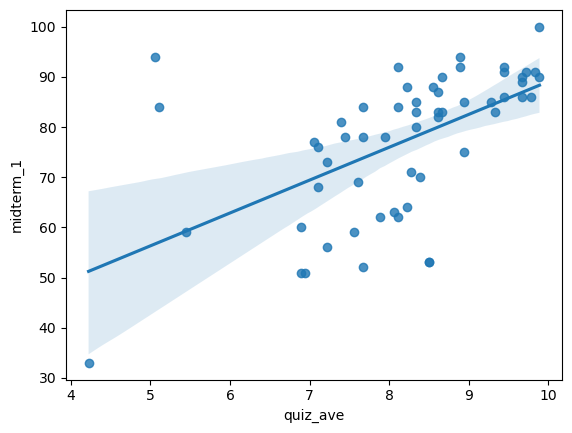

In [6]:
midterm_regression_df = agg_score_df.copy()
midterm_regression_df["midterm_1"] = scores_df.midterm_1
mt_reg = sns.regplot(data=midterm_regression_df, x="quiz_ave", y="midterm_1")

In [7]:
reg_x_values = mt_reg.get_lines()[0].get_xdata()
reg_y_values = mt_reg.get_lines()[0].get_ydata()
slope, intercept = np.polyfit(reg_x_values, reg_y_values, 1)

for student_id, midterm_1 in pd.DataFrame(midterm_regression_df.midterm_1).iterrows():
    if midterm_1.isna().iloc[0] == True:
        missing_quiz_ave = midterm_regression_df.loc[student_id, "quiz_ave"]
        midterm_1_inferred = slope * missing_quiz_ave + intercept
        scores_df = scores_df.replace(midterm_1, midterm_1_inferred)

scores_df.loc[8996487694, "midterm_1"]

48.319052851445036

# **Calculating Weighted Midterm Average**

Now that I have taken care of the missing midterm value I can calculate the weighted midterm average. However, similar to finding the quiz averages, this process is not very straightforward because the weighted average depends on the hierarchy of midterm scores for each unique student. I used an idea similar to calculating the quiz averages where I looped through each 'student_id' value and sliced the dataframes of midterm scores for each student and appended them to a list. Next, I looped through this list and sorted the midterm scores of each student so that I can calculate the weighted average according to the sorted midterm scores using the 'weighted_ave' function. Then I append each weighted average to a new list, which is precisely what is returned by the function, and add the weighted midterm averages to the 'agg_score_df'.  

In [8]:
def midterm_weighted_ave(midterm_scores):
    midterm_list = []
    midterm_weighted_ave = []
    
    for i in midterm_scores.index:
        midterm_list.append(midterm_scores.loc[i, :])
    
    def weighted_ave(midterm_scores):
         return (midterm_scores.iloc[0] * .45) + (midterm_scores.iloc[1] * .35) + (midterm_scores.iloc[2] * .2)
    
    for student in midterm_list:
        student = student.sort_values(ascending=False)
        midterm_weighted_ave.append(weighted_ave(student))

    return midterm_weighted_ave

midterm_scores = scores_df.loc[:,"midterm_1":"midterm_3"]
midterm_weighted_ave = midterm_weighted_ave(midterm_scores)
agg_score_df["weighted_midterm_ave"] = np.array(midterm_weighted_ave)
agg_score_df.head()

,quiz_ave,weighted_midterm_ave
student_id,,
1367593690,7.111111,64.75
1567876630,7.666667,75.70
1617655608,8.111111,75.35
1830694822,6.888889,56.95
2267294565,8.388889,69.60


# **Finalizing the Dataset Aggregation**

Now that I have aggregated the quiz and midterm averages, all that is left is to transfer the final scores from the original dataframe into the 'agg_score_df'. 

In [9]:
final_scores = scores_df.final
agg_score_df["final_score"] = scores_df.final
agg_score_df.head()

,quiz_ave,weighted_midterm_ave,final_score
student_id,,,
1367593690,7.111111,64.75,96.0
1567876630,7.666667,75.70,69.0
1617655608,8.111111,75.35,94.0
1830694822,6.888889,56.95,52.0
2267294565,8.388889,69.60,79.0


# **Exploratory Data Analysis**

Before we begin the process of curving the aggregated scores, we should first perform some exploratory data analysis to get a sense of how student performance is distributed and determine the proper cut offs we will need to curve the scores, if needed. First, I want to visualize how student performance is distributed for each type of examination, so similar to lecture I created three histograms using seaborn. Looking at the final scores, we can see that some curving will be necessary because most of the scores are around 70-100 and because the final is out of 140 points we can infer from the histogram that the mean score for the final will be fairly low. On the other hand, looking at the quiz averages I immediately noticed that many students are already within the range of a B or an A. So, looking at just the plot I do not feel there is any need to put a significant curve on the quiz averages because the scores are quite high as they are. Looking now at the midterm scores we can see that a curve is also unnecessary because the scores are already left skewed and a clear majority of the class is performing above a 70. Thus, the weighted average is the only 'curve' needed for the midterms and we do not need to further manipulate the distribution of midterm scores. I wanted to back up my visual analysis with some actual statistics so I used the 'describe()' method for the 'agg_score_df' to get some basic statistics for student performance. We can see that the quiz average is already a B- and the 25th percentile is a 7.47 meaning that a large majority of students already have at least a C for the quizzes. On the other hand, the mean for the final exam was around a 60% and so clearly we will need a curve for the final scores. Furthermore, the midterm average is around 77 which is an ideal value and thus curving will not be necessary. 

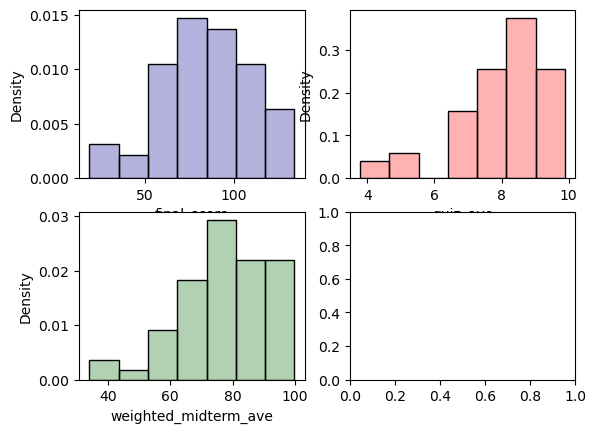

In [10]:
fig, ax = plt.subplots(2,2)
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.autolayout"] = True
sns.histplot(agg_score_df, x="final_score", stat='density', fill=True, alpha=0.3, legend=True, bins =7, color='darkblue', ax=ax[0, 0]);
sns.histplot(agg_score_df, x="quiz_ave", stat='density', fill=True, alpha=0.3, legend=True, bins =7, color='red', ax=ax[0, 1]);
sns.histplot(agg_score_df, x="weighted_midterm_ave", stat='density', fill=True, alpha=0.3, 
             legend=True, bins =7, color='darkgreen', ax=ax[1, 0]);

In [11]:
agg_score_df.describe()

,quiz_ave,weighted_midterm_ave,final_score
count,58.000000,58.000000,58.000000
mean,8.083333,76.992993,84.672414
std,1.359803,14.387878,26.802977
min,3.777778,34.043574,19.000000
25%,7.472222,67.237500,66.000000
50%,8.305556,78.425000,84.500000
75%,8.930556,86.537500,103.000000
max,9.888889,99.800000,134.000000


# **Curving the Final**

After doing the exploratory analysis, I decided that the final scores would indeed need curving. So, I will use quantile curving for this process which will allow me to fit the fairly low final scores into a better performance distribution that is more uniform and boosts the overall grades. I used the 'quantile' method to determine the 12 cut offs for each letter grade and set the first cut off to 0 so that all possible low scores are included in the bottom cut off. The curved final was then determined using the cut function and I renamed the categories for the quantiles to assign letter grades for the cut off interval that each student falls into. Finally, I updated the 'agg_score_df' with the curved final letter grades and created a histogram to visualize the distribution of the curved final grades. The histogram of the curved scores is clearly more unfiormly distributed then the raw final scores as we expected to see and we have successfully boosted student performance for the final. 

In [12]:
letter_grades = ["F", "D-", "D", "D+", "C-", "C", "C+", "B-", "B", "B+", "A-", "A"]

In [13]:
cut_offs = agg_score_df.final_score.quantile(np.arange(0, 1 + 1/12, 1/12))
cut_offs[0] = 0
curved_final = pd.cut(agg_score_df.final_score, bins=cut_offs)
agg_score_df["curved_final"] = curved_final.cat.rename_categories(letter_grades)
agg_score_df.sort_values("final_score", ascending=False).head()

,quiz_ave,weighted_midterm_ave,final_score,curved_final
student_id,,,,
6011937372,9.888889,99.80,134.0,A
8223787343,9.722222,98.20,129.0,A
4916395511,9.444444,97.25,127.0,A
5856390535,9.833333,94.30,126.0,A
3753516619,9.777778,83.95,126.0,A


<Axes: xlabel='curved_final', ylabel='Count'>

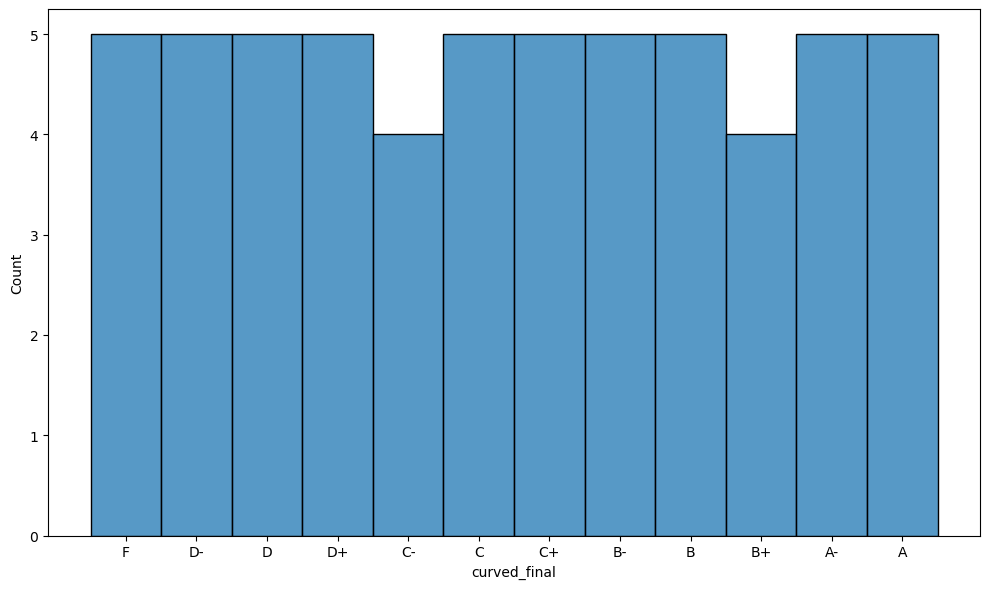

In [14]:
sns.histplot(agg_score_df, x="curved_final")

# **Curving the Midterm Averages**

I decided not to use quantile curving for the midterm scores because the midterm score histogram was left skewed and so if we used quantile curving and make the distribution of grades more uniform, we run the risk of actually curving down certain students who might be on the edge of their letter grade. To test this suspicion I actually created the quantile cut offs that would have been used had I decided to curve the scores, and we can see that quantile curving would have actually curved down students with scores of around 90-92 to a B+. Also, the quantiles are very inconsistent in length which means that the difference between say a B- and B is a matter of one or two points. So, I decided to use the standard cutoffs for the letter grades as seen below and used the cut function similar to before in order to get the midterm letter grades. I decided to plot a histogram of the midterm letter grades to get a visual sense of the distribution and as we can see, the grades are distributed nicely through each overall letter grade with students performing well overall. 

In [15]:
quantile_cut_offs = agg_score_df.weighted_midterm_ave.quantile(np.arange(0, 1 + 1/12, 1/12))
quantile_cut_offs

0.000000    34.043574
0.083333    58.450000
0.166667    64.300000
0.250000    67.237500
0.333333    72.000000
0.416667    74.250000
0.500000    78.425000
0.583333    80.750000
0.666667    85.350000
0.750000    86.537500
0.833333    91.825000
0.916667    95.937500
1.000000    99.800000
Name: weighted_midterm_ave, dtype: float64

In [16]:
mt_cut_offs = [0, 60, 63, 67, 70, 73, 77, 80, 83, 87, 90, 93, 100]
curved_mt = pd.cut(agg_score_df.weighted_midterm_ave, bins=mt_cut_offs)
agg_score_df["curved_midterms"] = curved_mt.cat.rename_categories(letter_grades)
agg_score_df.sort_values("quiz_ave", ascending=False).head()

,quiz_ave,weighted_midterm_ave,final_score,curved_final,curved_midterms
student_id,,,,,
6011937372,9.888889,99.80,134.0,A,A
3053107449,9.888889,96.05,99.0,B-,A
5856390535,9.833333,94.30,126.0,A,A
3753516619,9.777778,83.95,126.0,A,B
8223787343,9.722222,98.20,129.0,A,A


<Axes: xlabel='curved_midterms', ylabel='Count'>

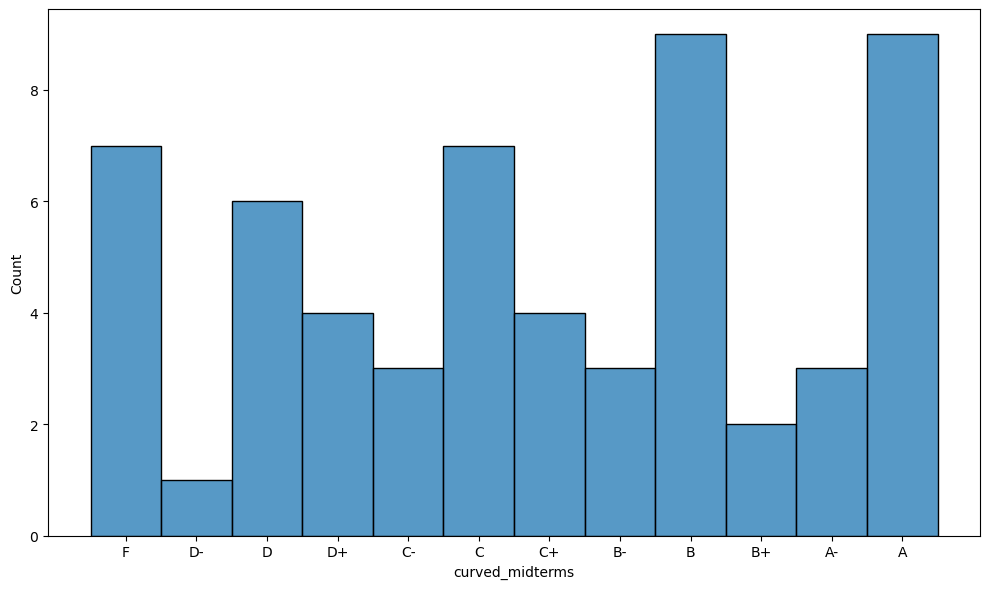

In [17]:
sns.histplot(agg_score_df, x="curved_midterms")

# **Curving the Quiz Averages**

To assign a letter grade for the quiz averages I used a similar process to the way I assigned the midterm letter grades. Because I decided that no curve was necessary for the quiz scores from the exploratory analysis, I used standard grade cutoffs and the cut function to assign the letter grades. Similar to before, I also plotted a histogram of the letter grade distribution and as we can see most students performed well on there quizzes so no further curving is needed. 

In [18]:
quiz_cut_offs = [0, 6, 6.3, 6.7, 7, 7.3, 7.7, 8, 8.3, 8.7, 9, 9.3, 10]
curved_quiz = pd.cut(agg_score_df.quiz_ave, bins=quiz_cut_offs)
agg_score_df["curved_quiz"] = curved_quiz.cat.rename_categories(letter_grades) 
agg_score_df.head()

,quiz_ave,weighted_midterm_ave,final_score,curved_final,curved_midterms,curved_quiz
student_id,,,,,,
1367593690,7.111111,64.75,96.0,B-,D,C-
1567876630,7.666667,75.70,69.0,D+,C,C
1617655608,8.111111,75.35,94.0,C+,C,B-
1830694822,6.888889,56.95,52.0,D-,F,D+
2267294565,8.388889,69.60,79.0,C-,D+,B


<Axes: xlabel='curved_quiz', ylabel='Count'>

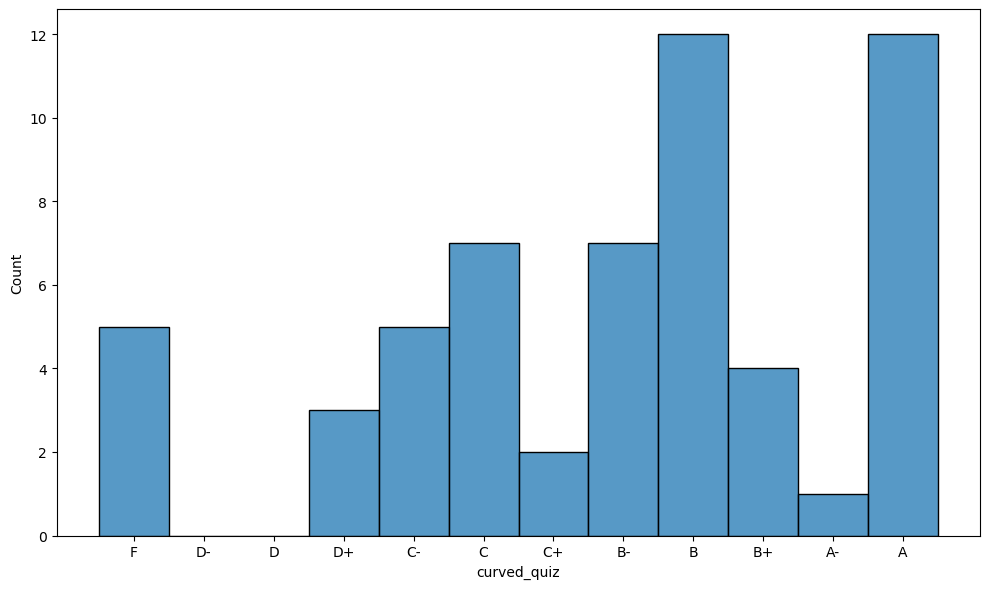

In [19]:
sns.histplot(agg_score_df, x="curved_quiz")

# **Finding the Weighted GPA Average**

Now that I have assigned letter grades for each students performances, I need to calculate the weighted GPA average which will be used to assign the final letter grades to each student. To do so, I create a dictionary mapping of each letter grade to its respective GPA score using the zip function. Next, I will slice out the letter grades for each student performance from the 'agg_score_df' and append each individual letter grade dataframe to a list. Then I loop through each student's letter grades and calculate the GPA average by using the dictionary mapping to find the associated score for each letter grade and multiply that value by its respective weighting. After appending all the weighted averages to a list, I added them as a new column to the 'agg_score_df'.

In [20]:
gpa = [0, 0.7, 1, 1.3, 1.7, 2, 2.3, 2.7, 3, 3.3, 3.7, 4]
gpa_map = dict(zip(letter_grades, gpa))

curved_letter_grades = []
for i in agg_score_df.index:
    curved_letter_grades.append(agg_score_df.loc[i, "curved_final":])

weights = {"quiz":.15, "midterm":.45, "final":.4}
gpa_course_ave = []
for student in curved_letter_grades:
    weighted_gpa = (gpa_map[student.iloc[0]] * weights["final"]) + (gpa_map[student.iloc[1]] * weights["midterm"]) + (gpa_map[student.iloc[2]] * weights["quiz"])
    gpa_course_ave.append(weighted_gpa)

agg_score_df["gpa_weighted_ave"] = gpa_course_ave

# **Determining Coures Letter Grades**

In order to determine the overall course letter grades for each student I used the weighted GPA average I just calculated and used the cut function with the provided cut offs to assign each students weighted GPA score to an interval determined by the cut offs that will correspond to their final letter grade. After using the cut function I was able to rename the category that each student fell into similar to how I assigned letter grades for each individual performance prior. I then removed some redundant columns from the 'agg_score_df' and only kept the nececssary columns with the addition of the overall letter grades. Lastly, I decided to create a histogram of the overall letter grades to get a sense of how the overall distribution looks. As we can see, the grades are distributed well throughout with a high concentration of students getting C's, which is what we are ideally looking for. Thus, we have successfully determined the overall letter grades for each student. 

In [21]:
gpa_cut_offs = [0, 0.55, 0.85, 1.15, 1.55, 1.85, 2.15, 2.55, 2.85, 3.15, 3.55, 3.85, 4]
gpa_categories = pd.cut(agg_score_df.gpa_weighted_ave, bins=gpa_cut_offs, include_lowest=True)
agg_score_df["course_grade"] = gpa_categories.cat.rename_categories(letter_grades)
agg_score_df = agg_score_df.loc[:,["quiz_ave", "weighted_midterm_ave", "final_score", "gpa_weighted_ave", "course_grade"]]
agg_score_df.sort_values("course_grade", ascending=False).head()

,quiz_ave,weighted_midterm_ave,final_score,gpa_weighted_ave,course_grade
student_id,,,,,
5856390535,9.833333,94.30,126.0,4.00,A
3687160969,9.444444,95.90,112.0,3.88,A
8223787343,9.722222,98.20,129.0,4.00,A
6011937372,9.888889,99.80,134.0,4.00,A
4916395511,9.444444,97.25,127.0,4.00,A


<Axes: xlabel='course_grade', ylabel='Count'>

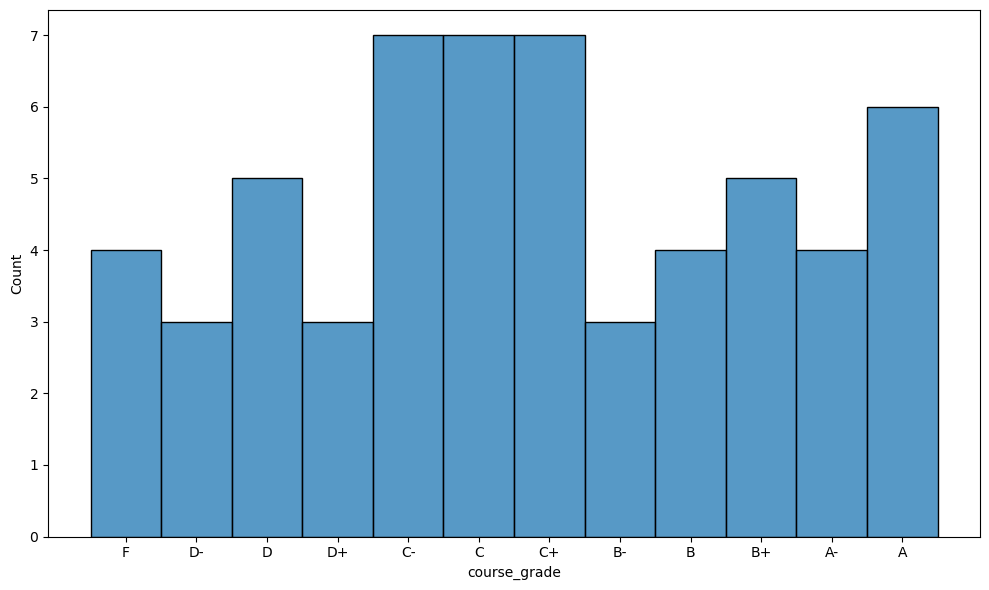

In [22]:
sns.histplot(agg_score_df, x="course_grade")